In [286]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
plt.style.use('dark_background')

params = {'figure.figsize': (15, 5),
         'axes.labelsize': 14,
         'axes.titlesize': 14,
          'axes.titlesize': 18}
pylab.rcParams.update(params)

In [287]:
# read data
cols = ['Bloomberg Code',
        '2',
        'Bid Price',
        'Ask Price',
        'Trade Price',
        'Bid Volume',
        'Ask Volume',
        'Trade Volume',
        'Update Type',
        '10',
        'Date',
        'Seconds past midnight',
        'Opening Price',
        '14',
        'Condition Codes',
        '16']
data = pd.read_csv('data/scandi.csv',names=cols)

In [288]:
data

,Bloomberg Code,2,Bid Price,Ask Price,Trade Price,Bid Volume,Ask Volume,Trade Volume,Update Type,10,Date,Seconds past midnight,Opening Price,14,Condition Codes,16
0,BBHBEAT Index,59,121.40,125.40,123.40,1234,1234,1234,2,0,20150420,28264.0,0.00,0,@1,NaN
1,BBHBEAT Index,60,121.40,125.40,123.40,1234,1234,1234,2,0,20150420,28265.0,0.00,0,@1,NaN
2,BBHBEAT Index,61,121.40,125.40,123.40,1234,1234,1234,2,0,20150420,28266.0,0.00,0,@1,NaN
3,BBHBEAT Index,62,121.40,125.40,123.40,1234,1234,1234,2,0,20150420,28267.0,0.00,0,@1,NaN
4,BBHBEAT Index,63,121.40,125.40,123.40,1234,1234,1234,2,0,20150420,28268.0,0.00,0,@1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13260272,LUPE SS Equity,3853814,137.80,138.80,138.60,10157,4677,298449,2,0,20150423,59700.0,138.60,298327,NaN,@1
13260273,WRT1V FH Equity,3853815,42.40,43.10,42.95,150,100,141176,2,0,20150423,59700.0,42.92,134634,NaN,@1
13260274,KRA1V FH Equity,3853816,10.91,10.97,10.93,1740,1569,53741,3,0,20150423,59700.0,10.93,53741,NaN,@1
13260275,BBHBEAT Index,3853817,121.40,125.40,123.40,1234,1234,1234,2,0,20150423,59700.0,0.00,0,@1,NaN


In [289]:
# drop unused rows
df = data.drop(['2','10','14','16'], axis=1).fillna(0)

In [290]:
# sort
df_sorted = df.sort_values(by=['Bloomberg Code','Date','Seconds past midnight'])
# remove auction events
df_remove_auc = df_sorted.loc[(df_sorted['Ask Price'] > df_sorted['Bid Price'])]
# remove conditions codes that are not 0 or XT
df_conditions_filtered = df_remove_auc[(df_remove_auc['Condition Codes'] == 0) | (df_remove_auc['Condition Codes'] == 'XT')]
# df with trades only
df_trades = df_conditions_filtered[(df_conditions_filtered['Update Type'] == 1)]

In [291]:
print(df_sorted.shape)
print(df_remove_auc.shape)
print(df_conditions_filtered.shape) # number of ticks
print(df_trades.shape) # number of trades

(13260277, 12)
(13099801, 12)
(12969198, 12)
(1516299, 12)


In [292]:
df_trades['time between trades'] = df_trades['Seconds past midnight'].diff()
df_conditions_filtered['time between ticks'] = df_conditions_filtered['Seconds past midnight'].diff()
df_trades['bid ask spread'] = df_trades['Ask Price'] - df_trades['Bid Price']

<ipython-input-292-3ce646a041f7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trades['time between trades'] = df_trades['Seconds past midnight'].diff()
<ipython-input-292-3ce646a041f7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_conditions_filtered['time between ticks'] = df_conditions_filtered['Seconds past midnight'].diff()
<ipython-input-292-3ce646a041f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [293]:
mean_spread = df_trades.groupby('Bloomberg Code')['bid ask spread'].mean()
median_spread = df_trades.groupby('Bloomberg Code')['bid ask spread'].median()

# if time between trades is negative, it means that we have entered a new day, hence filter it out
mean_time_trades = df_trades[df_trades['time between trades'] >= 0].groupby('Bloomberg Code')['time between trades'].mean()
median_time_trades = df_trades[df_trades['time between trades'] >= 0].groupby('Bloomberg Code')['time between trades'].median()
max_time_trades = df_trades[df_trades['time between trades'] >= 0].groupby('Bloomberg Code')['time between trades'].max()

mean_time_ticks = df_conditions_filtered[df_conditions_filtered['time between ticks'] >= 0].groupby('Bloomberg Code')['time between ticks'].mean()
median_time_ticks = df_conditions_filtered[df_conditions_filtered['time between ticks'] >= 0].groupby('Bloomberg Code')['time between ticks'].median()
max_time_ticks = df_conditions_filtered[df_conditions_filtered['time between ticks'] >= 0].groupby('Bloomberg Code')['time between ticks'].max()

# total daily volume for each day
vol = df_trades.groupby(['Bloomberg Code','Date'])['Trade Volume'].sum()
# averaged daily volume across 4 days
vol_agg = vol.groupby('Bloomberg Code').mean()
# averaged trade prices across 4 days
price_agg = df_trades.groupby('Bloomberg Code')['Trade Price'].mean()

# concat
mean_time_trades = pd.concat([mean_time_trades,vol_agg,price_agg],axis=1).sort_values(by='Trade Volume')
max_time_trades = pd.concat([max_time_trades,vol_agg,price_agg],axis=1).sort_values(by='Trade Volume')
mean_time_ticks = pd.concat([mean_time_ticks,vol_agg,price_agg],axis=1).sort_values(by='Trade Volume')
max_time_ticks = pd.concat([max_time_ticks,vol_agg,price_agg],axis=1).sort_values(by='Trade Volume')

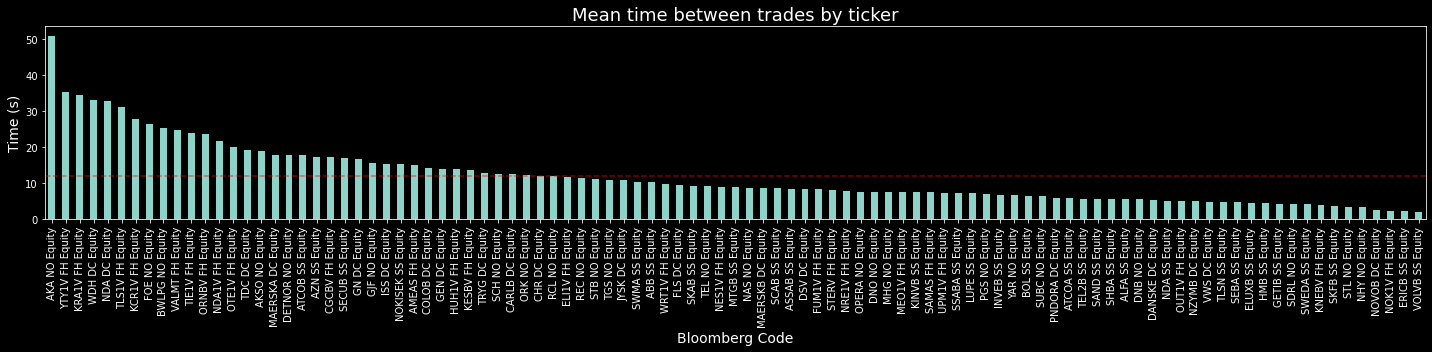

In [294]:
plt.figure(figsize=(20,5))
mean_time_trades.sort_values(by='time between trades',ascending=False)['time between trades'].plot.bar(title='Mean time between trades by ticker')
plt.axhline(mean_time_trades['time between trades'].mean(), color='r', linestyle='--', alpha=0.5)
plt.ylabel('Time (s)')
plt.tight_layout()
#plt.savefig('plots/meantimetrades.eps')

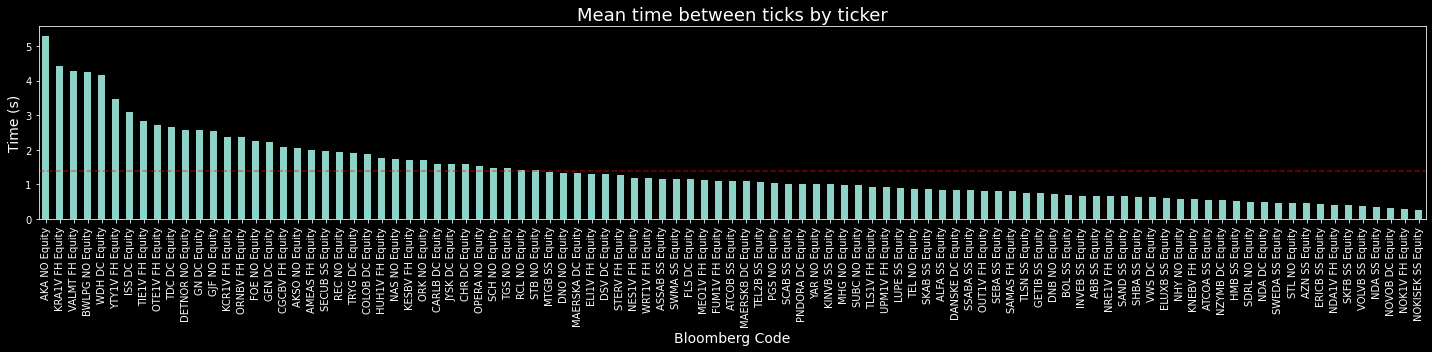

In [295]:
plt.figure(figsize=(20,5))
mean_time_ticks.sort_values(by='time between ticks', ascending=False)['time between ticks'].plot.bar(title='Mean time between ticks by ticker')
plt.axhline(mean_time_ticks['time between ticks'].mean(), color='r', linestyle='--', alpha=0.5)
plt.ylabel('Time (s)')
plt.tight_layout()
#plt.savefig('plots/meantimeticks.eps')

Text(0, 0.5, 'Time (s)')

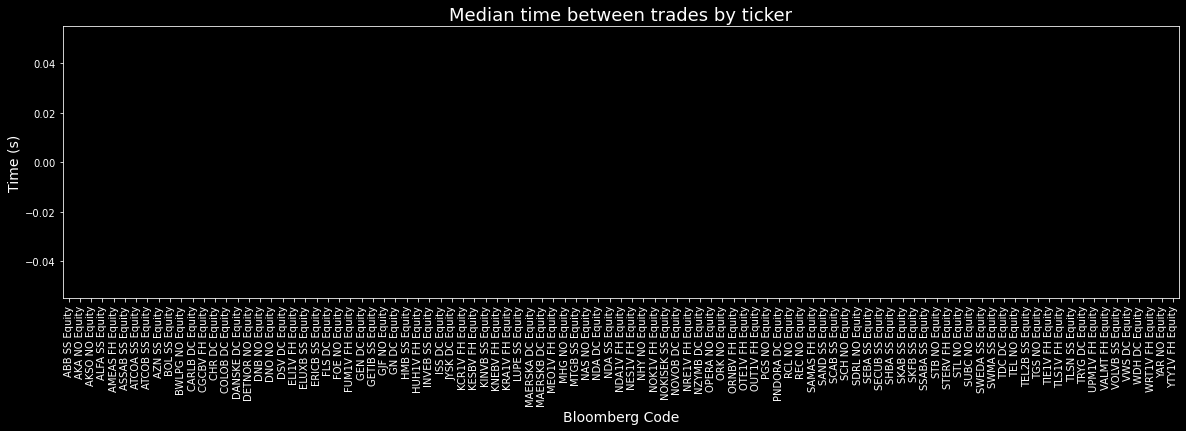

In [296]:
plt.figure(figsize=(20,5))
median_time_trades.plot.bar(title='Median time between trades by ticker')
plt.ylabel('Time (s)')

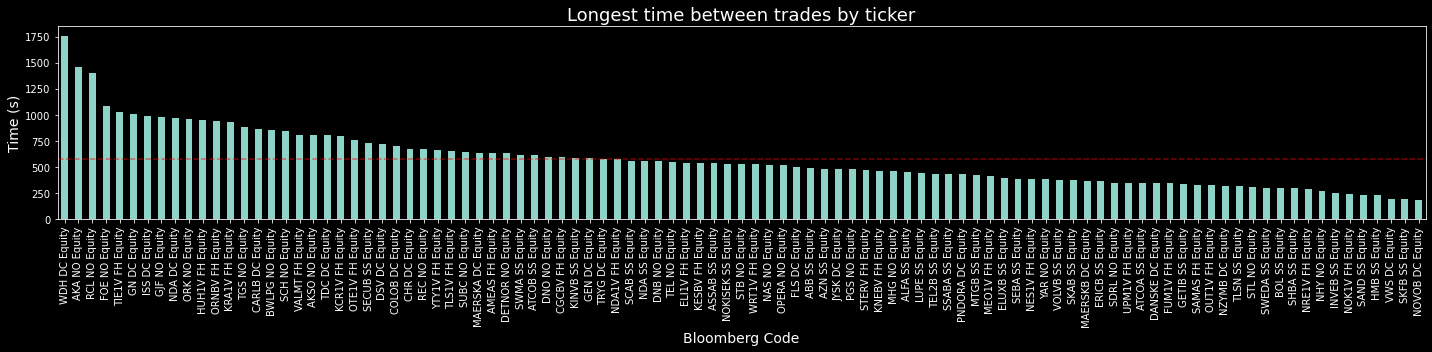

In [297]:
plt.figure(figsize=(20,5))
max_time_trades.sort_values(by='time between trades', ascending=False)['time between trades'].plot.bar(title='Longest time between trades by ticker')
plt.axhline(max_time_trades['time between trades'].mean(), color='r', linestyle='--', alpha=0.5)
plt.ylabel('Time (s)')
plt.tight_layout()
#plt.savefig('plots/maxtimetrades.eps')


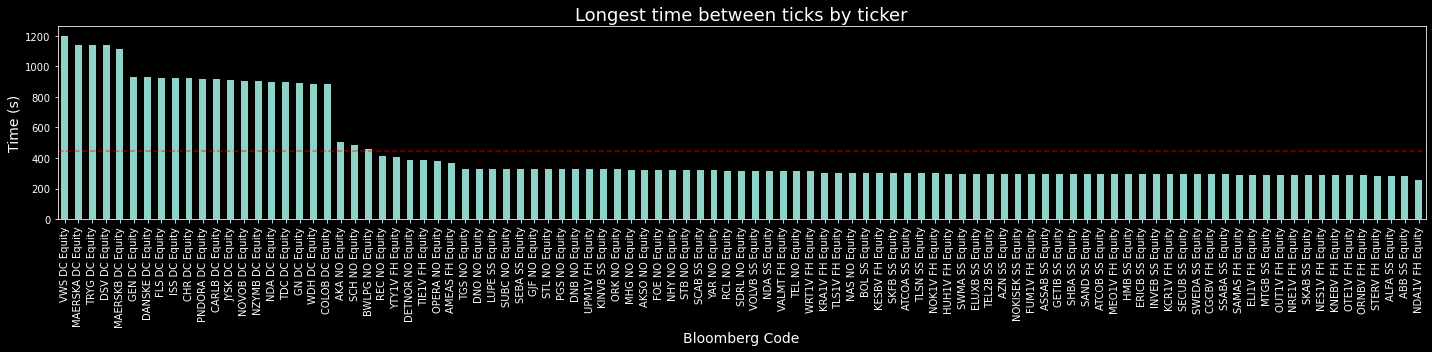

In [298]:
plt.figure(figsize=(20,5))
max_time_ticks.sort_values(by='time between ticks', ascending=False)['time between ticks'].plot.bar(title='Longest time between ticks by ticker')
plt.axhline(max_time_ticks['time between ticks'].mean(), color='r', linestyle='--', alpha=0.5)
plt.ylabel('Time (s)')
plt.tight_layout()
#plt.savefig('plots/maxtimeticks.eps')

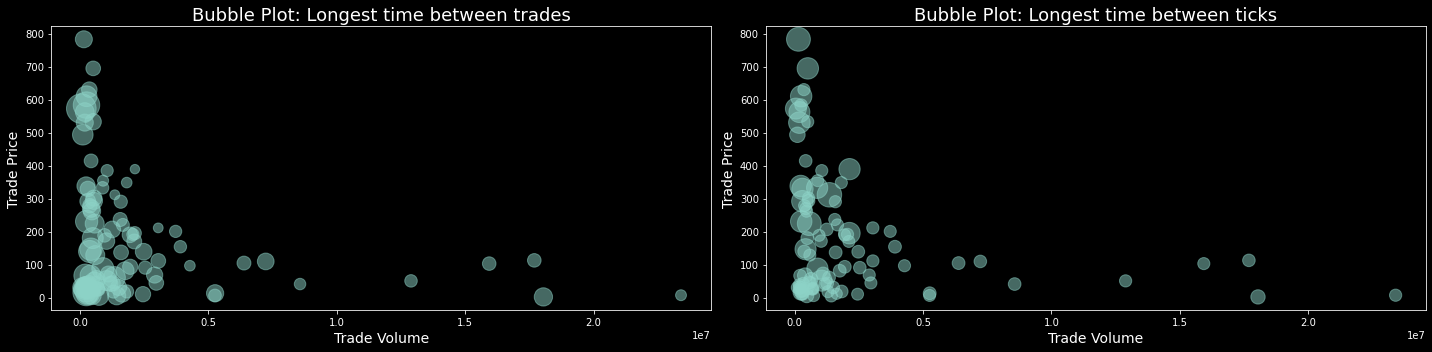

In [299]:
max_time_trades.drop(['MAERSKA DC Equity','MAERSKB DC Equity'],axis=0,inplace=True)
max_time_ticks.drop(['MAERSKA DC Equity','MAERSKB DC Equity'],axis=0,inplace=True)

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.scatter(max_time_trades['Trade Volume'],max_time_trades['Trade Price'], 
             s=max_time_trades['time between trades']*0.5,
             alpha=0.5)
plt.xlabel('Trade Volume')
plt.ylabel('Trade Price')
plt.title('Bubble Plot: Longest time between trades')
plt.subplot(122)
plt.scatter(max_time_ticks['Trade Volume'],max_time_ticks['Trade Price'], 
             s=max_time_ticks['time between ticks']*0.5,
             alpha=0.5)
plt.xlabel('Trade Volume')
plt.ylabel('Trade Price')
plt.title('Bubble Plot: Longest time between ticks')
plt.tight_layout()
#plt.savefig('plots/maxtimebubble.eps')

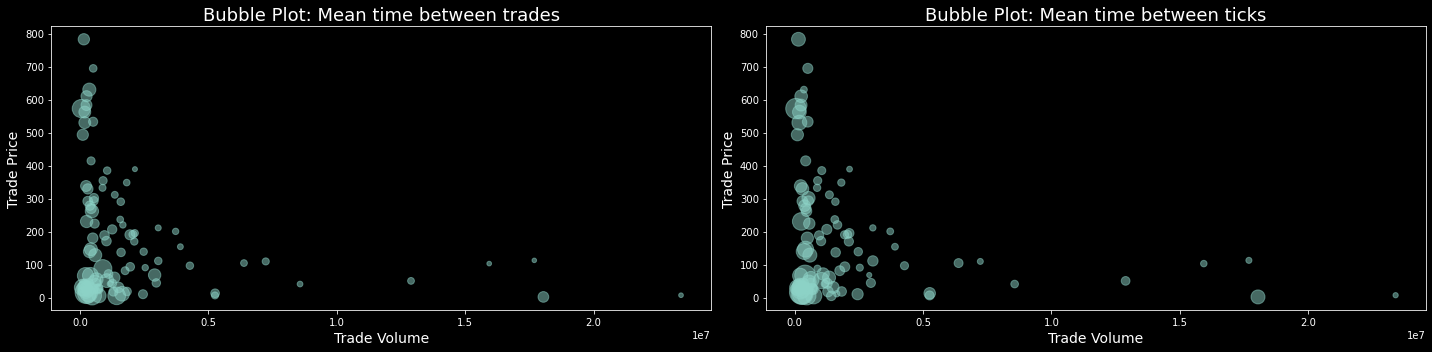

In [301]:
mean_time_trades.drop(['MAERSKA DC Equity','MAERSKB DC Equity'],axis=0,inplace=True)
mean_time_ticks.drop(['MAERSKA DC Equity','MAERSKB DC Equity'],axis=0,inplace=True)

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.scatter(mean_time_trades['Trade Volume'],mean_time_trades['Trade Price'], 
             s=mean_time_trades['time between trades']*10,
             alpha=0.5)
plt.xlabel('Trade Volume')
plt.ylabel('Trade Price')
plt.title('Bubble Plot: Mean time between trades')
plt.subplot(122)
plt.scatter(mean_time_ticks['Trade Volume'],mean_time_ticks['Trade Price'], 
             s=mean_time_ticks['time between ticks']*100,
             alpha=0.5)
plt.xlabel('Trade Volume')
plt.ylabel('Trade Price')
plt.title('Bubble Plot: Mean time between ticks')
plt.tight_layout()
#plt.savefig('plots/meantimebubble.eps')

Text(0, 0.5, 'Time (s)')

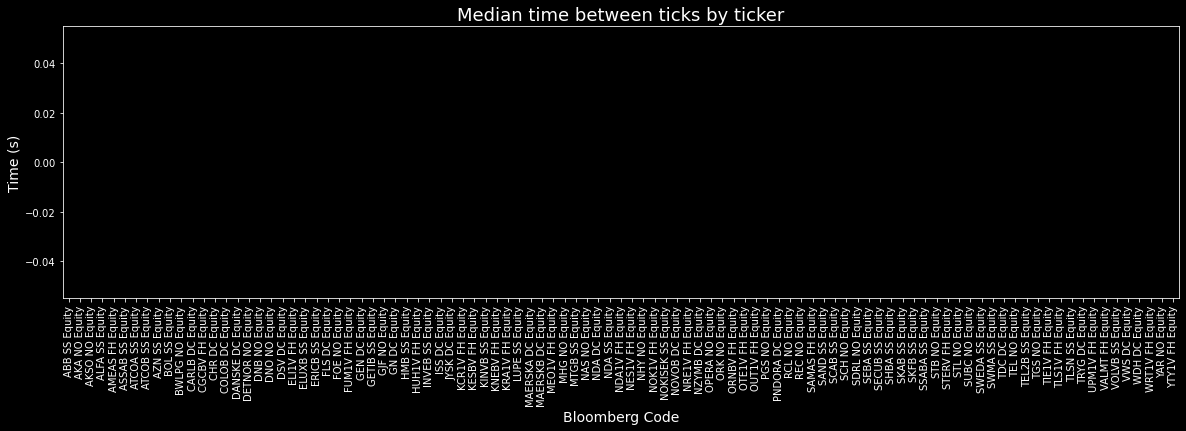

In [302]:
plt.figure(figsize=(20,5))
median_time_ticks.plot.bar(title='Median time between ticks by ticker')
plt.ylabel('Time (s)')

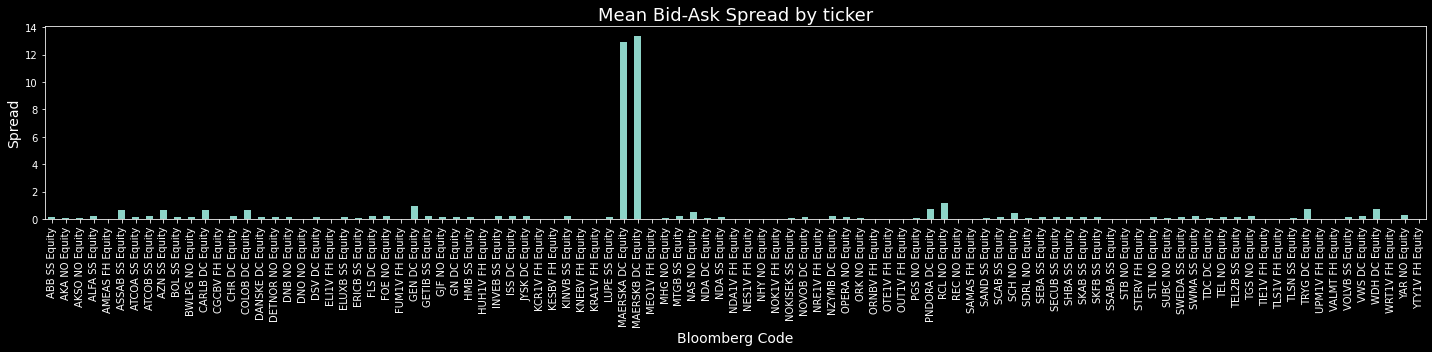

In [303]:
plt.figure(figsize=(20,5))
mean_spread.plot.bar(title='Mean Bid-Ask Spread by ticker')
plt.ylabel('Spread')
plt.tight_layout()
#plt.savefig('plots/meanspread.eps')

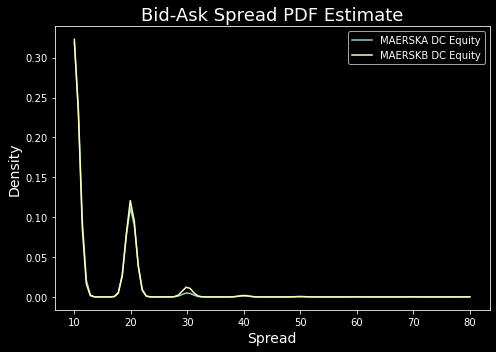

In [322]:
# PDF estimate code block
from scipy.stats.kde import gaussian_kde

sample = ['MAERSKA DC Equity','MAERSKB DC Equity']
plt.figure(figsize=(7,5))

for i in range(len(sample)):
    data = df_trades[df_trades['Bloomberg Code'] == sample[i]]['bid ask spread']
    # kernel
    kde = gaussian_kde(data)
    # Values over which the kernel will be evaluated
    dist_space = np.linspace(min(data), max(data), 100)

    plt.plot(dist_space, kde(dist_space))

plt.legend(sample)
plt.title('Bid-Ask Spread PDF Estimate')
plt.xlabel('Spread')
plt.ylabel('Density')
plt.tight_layout()
#plt.savefig('plots/spreadkde.eps')

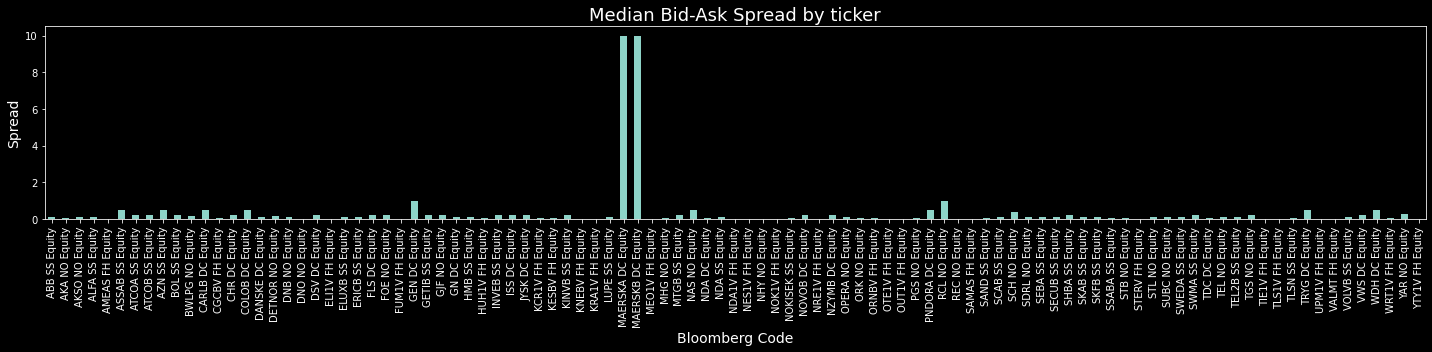

In [305]:
plt.figure(figsize=(20,5))
median_spread.plot.bar(title='Median Bid-Ask Spread by ticker')
plt.ylabel('Spread')
plt.tight_layout()
#plt.savefig('plots/medianspread.eps')

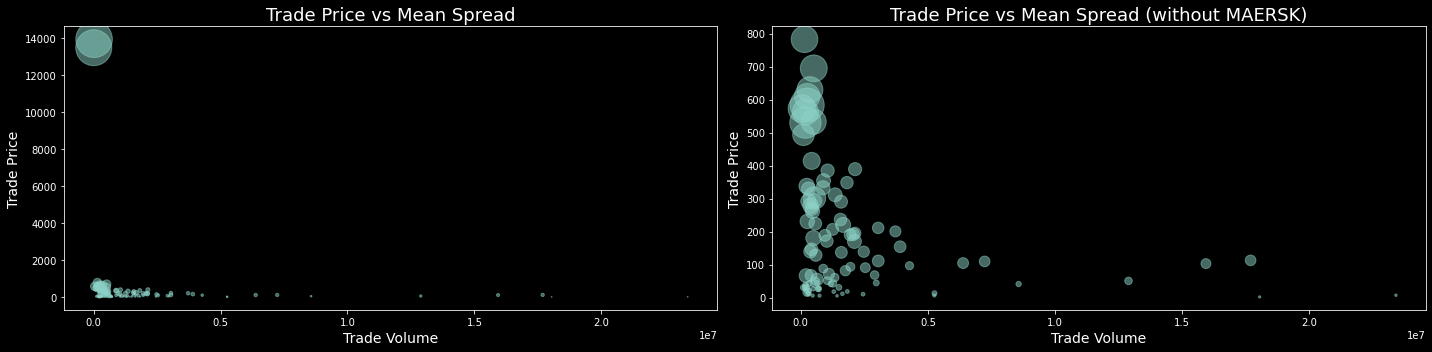

In [306]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.scatter(vol_agg, price_agg, s=mean_spread*100, alpha=0.5)
plt.xlabel('Trade Volume')
plt.ylabel('Trade Price')
plt.title('Trade Price vs Mean Spread')
plt.subplot(122)
plt.scatter(vol_agg.drop(['MAERSKA DC Equity','MAERSKB DC Equity'],axis=0), price_agg.drop(['MAERSKA DC Equity','MAERSKB DC Equity']), s=mean_spread.drop(['MAERSKA DC Equity','MAERSKB DC Equity'])*1000, alpha=0.5)
plt.xlabel('Trade Volume')
plt.ylabel('Trade Price')
plt.title('Trade Price vs Mean Spread (without MAERSK)')
plt.tight_layout()
#plt.savefig('plots/spreadscatter.eps')

# round trade price

In [311]:
# split trade price into whole number part and decimal part
def get_decimals(x):
    return x.split('.')[1]

def get_integers(x):
    return x.split('.')[0]

# Trade prices rounding conditions

def roundingAbove100(decimal):
    if decimal == '0':
        return 1
    else:
        return 0

def roundingBelow100(decimal):
    if decimal == '0' or decimal == '5':
        return 1
    else:
        return 0

def roundingBelow10(decimal):
    if len(decimal) == 1 or (len(decimal) == 2 and decimal == '5'):
        return 1
    else:
        return 0

def roundingAbove10000(integer):
    if integer[-2:] == '00':
        return 1
    else:
        return 0   

In [312]:
# split trade price into whole number part and decimal part
df_trades['Decimal'] = df_trades['Trade Price'].astype(str).apply(get_decimals)
df_trades['Integer'] = df_trades['Trade Price'].astype(str).apply(get_integers)

# apply trade price rounding conditions for different ranges of trade prices
df_0_10 = df_trades[ (df_trades['Trade Price'] >= 0) & (df_trades['Trade Price'] < 10) ]['Decimal'].apply(roundingBelow10)
df_0_10.name = 'round_count'
df_10_100 = df_trades[ (df_trades['Trade Price'] >= 10) & (df_trades['Trade Price'] < 100) ]['Decimal'].apply(roundingBelow100)
df_10_100.name = 'round_count'
df_100_1000 = df_trades[ (df_trades['Trade Price'] >= 100) & (df_trades['Trade Price'] < 1000) ]['Decimal'].apply(roundingAbove100)
df_100_1000.name = 'round_count'
df_10000 = df_trades[df_trades['Trade Price'] >= 10000]['Integer'].apply(roundingAbove10000)
df_10000.name = 'round_count'

# concat all
df_rc = pd.concat([df_0_10,df_10_100,df_100_1000,df_10000],axis=0)

# left join with trades dataframe
df_trades = df_trades.merge(df_rc, left_on=df_trades.index, right_index=True)

<ipython-input-312-7c45932a4675>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trades['Decimal'] = df_trades['Trade Price'].astype(str).apply(get_decimals)
<ipython-input-312-7c45932a4675>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trades['Integer'] = df_trades['Trade Price'].astype(str).apply(get_integers)


In [313]:
# calculate number of trades executed at round prices as a percentage of total trades made
trade_price_round_stats = df_trades.groupby('Bloomberg Code')['round_count'].agg(lambda x: x.eq(1).sum() / (x.eq(1).sum() + x.eq(0).sum()) )
trade_price_round_stats = pd.concat([trade_price_round_stats, price_agg, vol_agg], axis=1)

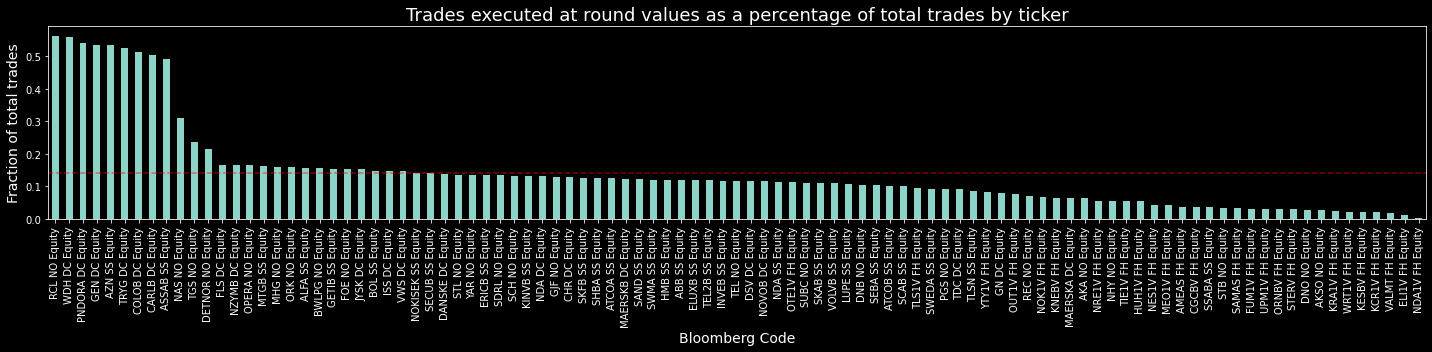

In [314]:
plt.figure(figsize=(20,5))
trade_price_round_stats.sort_values(by='round_count', ascending=False)['round_count'].plot.bar(title='Trades executed at round values as a percentage of total trades by ticker')
plt.axhline(trade_price_round_stats['round_count'].mean(), color='r', linestyle='--', alpha=0.5)
plt.ylabel('Fraction of total trades')
plt.tight_layout()
#plt.savefig('plots/tradeprice_roundcounts_bar.eps')

In [315]:
print(trade_price_round_stats.sort_values(by='round_count').head(10).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  round\_count &  Trade Price &  Trade Volume \\
Bloomberg Code  &              &              &               \\
\midrule
NDA1V FH Equity &     0.002148 &    11.759417 &    1639715.00 \\
ELI1V FH Equity &     0.012987 &    26.795886 &     495322.50 \\
VALMT FH Equity &     0.017340 &    11.237908 &     317306.75 \\
KCR1V FH Equity &     0.020235 &    30.656792 &     105406.75 \\
KESBV FH Equity &     0.020869 &    38.971584 &     189212.00 \\
WRT1V FH Equity &     0.020900 &    42.652275 &     333875.25 \\
KRA1V FH Equity &     0.023620 &    11.206187 &     270849.25 \\
AKSO NO Equity  &     0.027469 &    46.796205 &     561217.50 \\
DNO NO Equity   &     0.028879 &    13.248355 &    5259845.50 \\
STERV FH Equity &     0.029699 &    10.440365 &    2451554.50 \\
\bottomrule
\end{tabular}



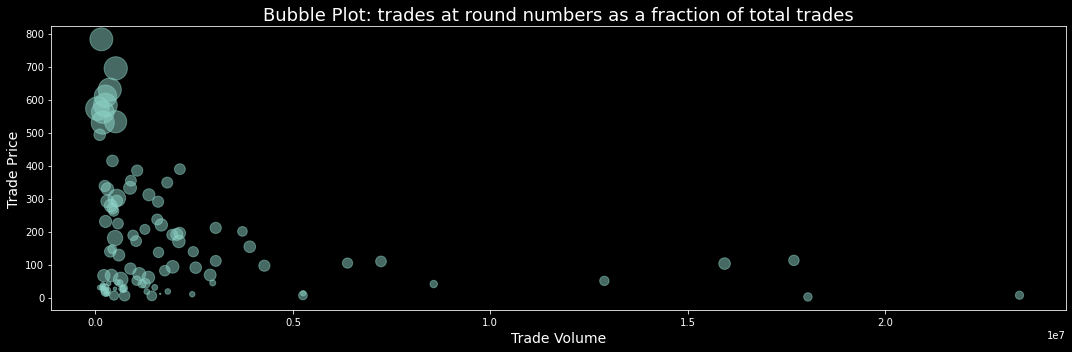

In [316]:
trade_price_round_stats.drop(['MAERSKA DC Equity','MAERSKB DC Equity'],axis=0,inplace=True)
plt.scatter(trade_price_round_stats['Trade Volume'],trade_price_round_stats['Trade Price'], 
             s=trade_price_round_stats['round_count']*1000,
             alpha=0.5)
plt.xlabel('Trade Volume')
plt.ylabel('Trade Price')
plt.title('Bubble Plot: trades at round numbers as a fraction of total trades')
plt.tight_layout()
#plt.savefig('plots/tradeprice_roundcounts_bubble.eps')

# round trade volumes

In [307]:
def volume_count(data):
    # counts the number of trades or ticks for trade volumes ending in 0 to 9
    
    if data == 'tick':
        master_vol_counts = {}
        for ticker in df_conditions_filtered['Bloomberg Code'].unique():
            counts = {
                '0': 0,
                '1': 0,
                '2': 0,
                '3': 0,
                '4': 0,
                '5': 0,
                '6': 0,
                '7': 0,
                '8': 0,
                '9': 0,
            }

            for vol in df_conditions_filtered[df_conditions_filtered['Bloomberg Code'] == ticker]['Trade Volume']:
                if str(vol)[-1] == '0':
                    counts['0'] += 1
                if str(vol)[-1] == '1':
                    counts['1'] += 1
                if str(vol)[-1] == '2':
                    counts['2'] += 1
                if str(vol)[-1] == '3':
                    counts['3'] += 1
                if str(vol)[-1] == '4':
                    counts['4'] += 1
                if str(vol)[-1] == '5':
                    counts['5'] += 1
                if str(vol)[-1] == '6':
                    counts['6'] += 1
                if str(vol)[-1] == '7':
                    counts['7'] += 1
                if str(vol)[-1] == '8':
                    counts['8'] += 1
                if str(vol)[-1] == '9':
                    counts['9'] += 1

            master_vol_counts[ticker] = counts
            
    if data == 'trade':
        master_vol_counts = {}
        for ticker in df_trades['Bloomberg Code'].unique():
            counts = {
                '0': 0,
                '1': 0,
                '2': 0,
                '3': 0,
                '4': 0,
                '5': 0,
                '6': 0,
                '7': 0,
                '8': 0,
                '9': 0,
            }

            for vol in df_trades[df_trades['Bloomberg Code'] == ticker]['Trade Volume']:
                if str(vol)[-1] == '0':
                    counts['0'] += 1
                if str(vol)[-1] == '1':
                    counts['1'] += 1
                if str(vol)[-1] == '2':
                    counts['2'] += 1
                if str(vol)[-1] == '3':
                    counts['3'] += 1
                if str(vol)[-1] == '4':
                    counts['4'] += 1
                if str(vol)[-1] == '5':
                    counts['5'] += 1
                if str(vol)[-1] == '6':
                    counts['6'] += 1
                if str(vol)[-1] == '7':
                    counts['7'] += 1
                if str(vol)[-1] == '8':
                    counts['8'] += 1
                if str(vol)[-1] == '9':
                    counts['9'] += 1

            master_vol_counts[ticker] = counts
        
    return master_vol_counts

In [308]:
trades_vol_counts = volume_count('trade')
tick_vol_counts = volume_count('tick')

In [309]:
# condition for 'round volume' is a trade volume that ends in '0'
tick_prob_0 = {}
for ticker in df_conditions_filtered['Bloomberg Code'].unique():
    tot = sum(tick_vol_counts[ticker].values())
    prob = tick_vol_counts[ticker]['0'] / tot
    tick_prob_0[ticker] = prob
    
tick_prob_0 = { key.replace('Equity', ''):value for key, value in tick_prob_0.items() }
tick_prob_0 = pd.DataFrame.from_dict(tick_prob_0, orient='index')
tick_prob_0.columns = ['Tick']

trades_prob_0 = {}
for ticker in df_trades['Bloomberg Code'].unique():
    tot = sum(trades_vol_counts[ticker].values())
    prob = trades_vol_counts[ticker]['0'] / tot
    trades_prob_0[ticker] = prob
    
trades_prob_0 = { key.replace('Equity', ''):value for key, value in trades_prob_0.items() }
trades_prob_0 = pd.DataFrame.from_dict(trades_prob_0, orient='index')
trades_prob_0.columns = ['Trades']

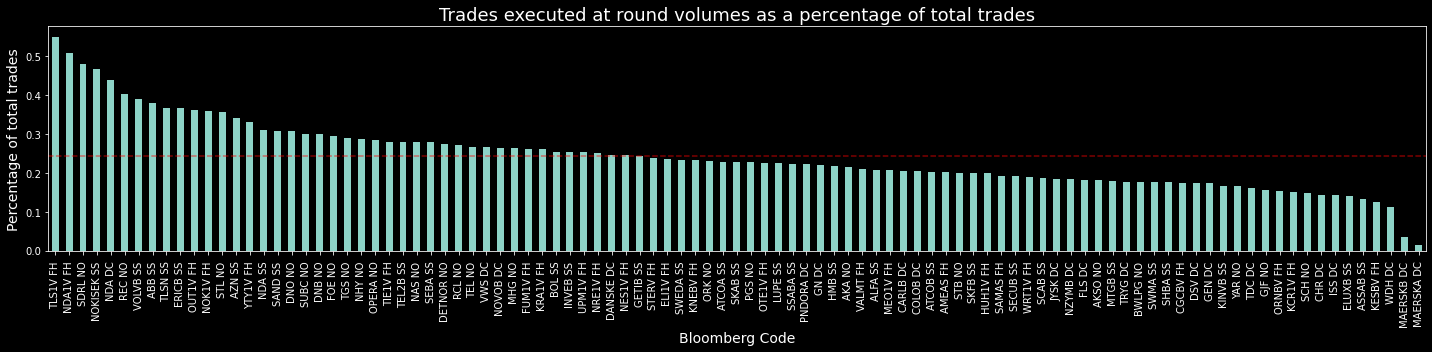

In [310]:
vols = pd.concat([tick_prob_0, trades_prob_0], axis=1)
plt.figure(figsize=(20,5))
vols['Trades'].sort_values(ascending=False).plot.bar()
plt.axhline(vols['Trades'].mean(), color='r', linestyle='--', alpha=0.5)
plt.title('Trades executed at round volumes as a percentage of total trades')
plt.xlabel('Bloomberg Code')
plt.ylabel('Percentage of total trades')
plt.tight_layout()
#plt.savefig('plots/roundedtradevolumes.eps')

# round trade price and trade volume

In [317]:
def round_vol(x):
    if x % 10 == 0:
        return 1
    else:
        return 0
    
def vol_px_round(x):
    if x[0] == 1 and x[1] == 1:
        return 1
    else:
        return 0

In [318]:
df_trades['round_vol'] = df_trades['Trade Volume'].apply(round_vol)
df_trades['round_vol_and_price'] = df_trades[['round_count','round_vol']].apply(vol_px_round, axis=1)

df_round_pcts = df_trades.groupby('Bloomberg Code')['round_count','round_vol','round_vol_and_price'].agg(lambda x: x.eq(1).sum() / (x.eq(1).sum() + x.eq(0).sum()) )

df_round_pcts = pd.concat([df_round_pcts, price_agg, vol_agg], axis=1)

<ipython-input-318-548aa14380c0>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_round_pcts = df_trades.groupby('Bloomberg Code')['round_count','round_vol','round_vol_and_price'].agg(lambda x: x.eq(1).sum() / (x.eq(1).sum() + x.eq(0).sum()) )


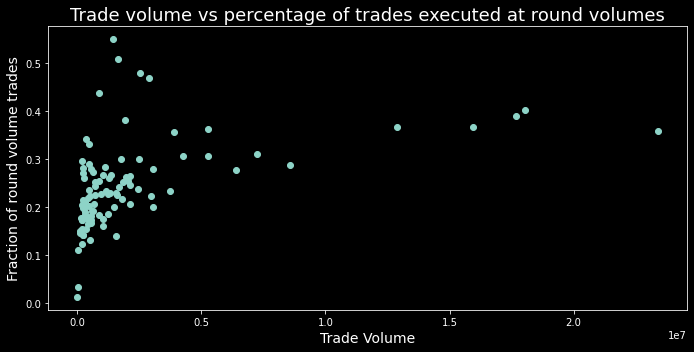

In [319]:
plt.figure(figsize=(10,5))
plt.scatter(
    df_round_pcts[['round_vol','Trade Price','Trade Volume']].sort_values(by='round_vol', ascending=False)['Trade Volume'],
    df_round_pcts[['round_vol','Trade Price','Trade Volume']].sort_values(by='round_vol', ascending=False)['round_vol']        
)
plt.xlabel('Trade Volume')
plt.ylabel('Fraction of round volume trades')
plt.title('Trade volume vs percentage of trades executed at round volumes')
plt.tight_layout()
#plt.savefig('plots/tradevolvspercentage.eps')

In [320]:
print(pd.concat([df_round_pcts.sort_values(by='round_vol_and_price', ascending=False).head(), df_round_pcts.sort_values(by='round_vol_and_price', ascending=False).tail()], axis=0).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  round\_count &  round\_vol &  round\_vol\_and\_price &   Trade Price &  Trade Volume \\
Bloomberg Code    &              &            &                      &               &               \\
\midrule
AZN SS Equity     &     0.533948 &   0.342310 &             0.181290 &    630.174734 &     362495.50 \\
RCL NO Equity     &     0.563105 &   0.271993 &             0.159668 &    583.385854 &     252023.25 \\
PNDORA DC Equity  &     0.541333 &   0.222548 &             0.123895 &    694.577486 &     513701.75 \\
COLOB DC Equity   &     0.512131 &   0.204430 &             0.109867 &    562.213046 &     185987.50 \\
CARLB DC Equity   &     0.503321 &   0.205770 &             0.106042 &    610.188922 &     254799.25 \\
ELI1V FH Equity   &     0.012987 &   0.235498 &             0.004425 &     26.795886 &     495322.50 \\
KCR1V FH Equity   &     0.020235 &   0.149920 &             0.003219 &     30.656792 &     105406.75 \\
KESBV FH Equity   &     0.020869

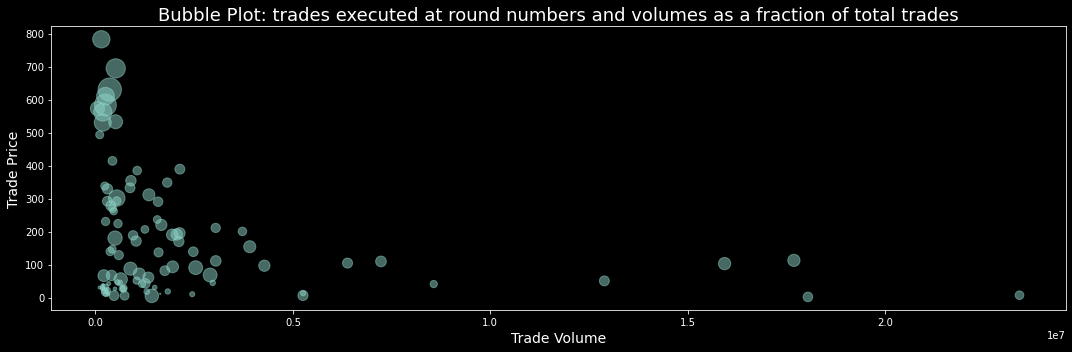

In [321]:
plt.scatter(vol_agg.drop(['MAERSKA DC Equity','MAERSKB DC Equity'],axis=0), price_agg.drop(['MAERSKA DC Equity','MAERSKB DC Equity'],axis=0), 
             s=df_round_pcts.drop(['MAERSKA DC Equity','MAERSKB DC Equity'])['round_vol_and_price']*3000,
             alpha=0.5
           )
plt.xlabel('Trade Volume')
plt.ylabel('Trade Price')
plt.title('Bubble Plot: trades executed at round numbers and volumes as a fraction of total trades')
plt.tight_layout()
#plt.savefig('plots/roundnumbersandvolumes.eps')

# not used

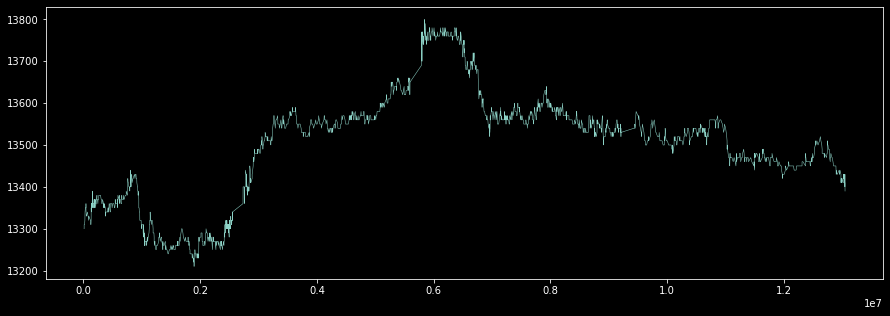

In [218]:
plt.plot(df_trades[df_trades['Bloomberg Code'] == 'MAERSKA DC Equity'][['Trade Price']], linewidth=0.5)

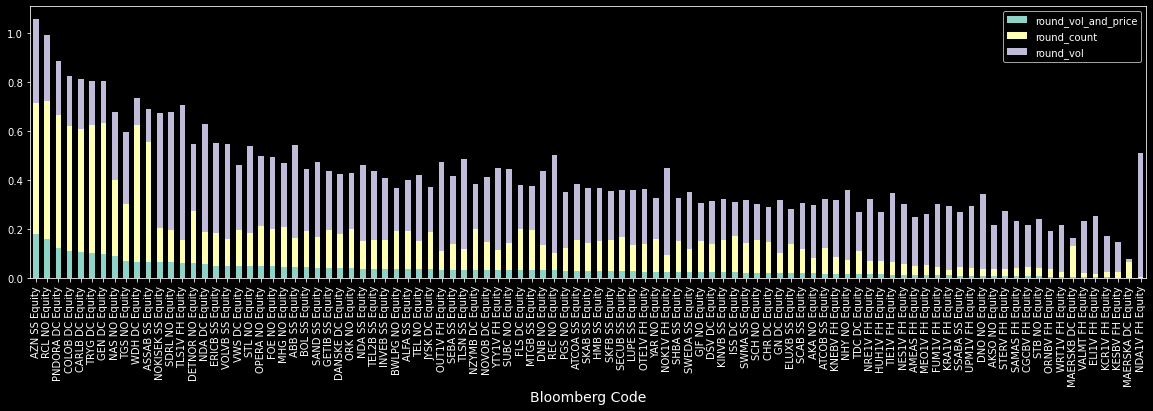

In [283]:
plt.figure(figsize=(20,5))
ax = plt.subplot(111)
df_round_pcts[['round_vol_and_price', 'round_count', 'round_vol']].sort_values(by='round_vol_and_price', ascending=False).plot.bar(ax=ax, stacked=True)

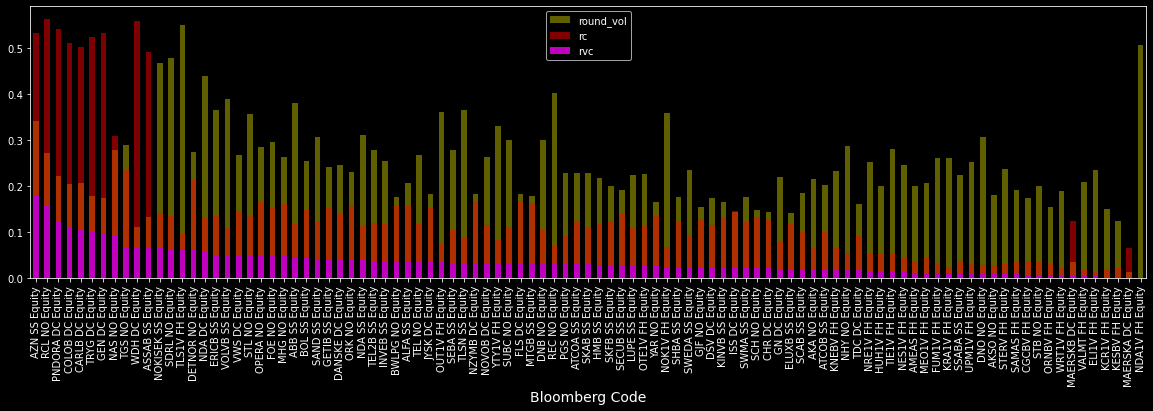

In [284]:
plt.figure(figsize=(20,5))
ax = plt.subplot(111)
df_round_pcts.sort_values(by='round_vol_and_price', ascending=False)['round_vol'].plot(ax=ax, kind='bar', color='y', alpha=0.5)
df_round_pcts.sort_values(by='round_vol_and_price', ascending=False)['round_count'].plot(ax=ax, kind='bar', color='r', alpha=0.5)

df_round_pcts.sort_values(by='round_vol_and_price', ascending=False)['round_vol_and_price'].plot(ax=ax, kind='bar', color='m',alpha=1)
#df_round_pcts['round_count'].plot.bar()
plt.legend(['round_vol','rc', 'rvc'])